In [7]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import sys

import numpy as np

class GAN():
    
    def init_v17_v10_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V10'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
            
    def init_v17_v14_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V14'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
        
    def load_fraud_data(self):
        # Read in dataset from csv file
        data = pd.read_csv("creditcard.csv")
        
        # Take only the fraud examples
        data_fraud = data.loc[data['Class'] == 1]
        
        # Remove class column as not needed, these are all Class=1
        data_fraud = data_fraud.loc[:, data_fraud.columns != 'Class']
        self.data_cols = data_fraud.columns
        
        # Scale data using StandardScaler
        pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(data_fraud)
        data_fraud = preprocessor.transform(data_fraud)
        data_fraud = pd.DataFrame(data_fraud, columns=self.data_cols)
        
        self.data_fraud = data_fraud
        
    def __init__(self):
        self.img_rows = 1 
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.00002, 0.5)
        
        # Load fraud data 
        self.load_fraud_data()
        # Initialise the data plot grid
#         self.init_v17_v10_plot()
        self.init_v17_v10_plot()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    

    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape))) # , activation='tanh'
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(2, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def generate_train_test_sample(self, data, test_ratio=0.3): 
        
        # Assign variables x and y corresponding to row data and it's class value
        X = data.ix[:, data.columns != 'Class']
        y = data.ix[:, data.columns == 'Class']

        # performs random split (i.e random selects 70% datapoints)
        X_train, X_test, y_train, y_test = train_test_split(X,y)
        
        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)

        return X_train_prp, X_test_prp, y_train, y_test
    
    def generate_train_test_timeseries(data, test_ratio=0.3):

        total_samples = data.shape[0]

        cutoff = int(total_samples * (1 - test_ratio))

        data.sort_values('Time', inplace=True)

        X_train = data.loc[0:cutoff, data.columns != 'Class']
        y_train = data.loc[0:cutoff, data.columns == 'Class']
        X_test = data.loc[cutoff:, data.columns != 'Class']
        y_test = data.loc[cutoff:, data.columns == 'Class']

        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)



        return X_train_prp, y_train, X_test_prp, y_test
    

    def train(self, epochs, batch_size=128, save_interval=200):
        
        data_cols = self.data_cols
        # Load the dataset
        X_train = self.data_fraud.values

        
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=1)

        half_batch = int(batch_size / 2)
        self.losses = []
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)
            
            self.discriminator.trainable = True
            # Train the discriminator
            X = np.concatenate((imgs,gen_imgs))
            y = np.zeros([len(imgs)+len(gen_imgs),2])
            y[0:len(imgs),1] = 1
            y[len(imgs):,0] = 1
            d_loss = self.discriminator.train_on_batch(X, y)
#             d_loss = [0.5 * (i+j) for i,j in (d_loss_real, d_loss_fake)]
#             d_loss = 0.5*(d_loss_real[0]+d_loss_fake[0])
#             d_acc = 0.5*(d_loss_real[1]+d_loss_fake[1])

            self.discriminator.trainable = False

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)
            valid_y = np.zeros([batch_size,2])
            valid_y[:,1] = 1
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            self.losses.append((d_loss, g_loss))

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, imgs, gen_imgs)
                
        self.save_loss_plot()
        
    def save_loss_plot(self):
        losses = np.array(self.losses)

        fig, ax = plt.subplots()
        plt.plot([i[0][0] for i in losses], label='Discriminator')
        plt.plot([i[1] for i in losses], label='Generator')
        plt.title("Training Losses")
        plt.legend()
        
        fig.savefig("GANv1-losses-600.png")
        plt.close()
        
    def save_imgs(self, epoch, img, gen_imgs):

        col1, col2 = 'V17', 'V10'
        noise = np.random.normal(0, 1, (492, 100))
        print(noise.shape)

            # Generate a half batch of new images
        gen_imgs = self.generator.predict(noise)

        gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[2])
        print (gen_imgs.shape)
        gen_samples = pd.DataFrame(gen_imgs, columns=self.data_cols)
        
        gen_samples.plot(kind='scatter', ax=self.axes[self.plot_counter,1], x = col1, y = col2)
        self.plot_counter = self.plot_counter +1
        
        if self.plot_counter == 6:
            self.fig.tight_layout()
            self.fig.savefig("GANv1-v17-v10-img_600.png")
            plt.close()
            
    
    def test_as_classifier(self):
        from sklearn.metrics import confusion_matrix, classification_report
        
        data_raw = pd.read_csv("creditcard.csv")
    
        X_train, X_test, y_train, y_test = self.generate_train_test_sample(data_raw)
        X_test = np.expand_dims(X_test, axis=3)
        X_test = np.expand_dims(X_test, axis=1)
        y_pred = self.discriminator.predict(X_test)

        cutt_off_tr = 0.5
        y_pred[np.where(y_pred>=cutt_off_tr)] = 1
        y_pred[np.where(y_pred<cutt_off_tr)]  = 0
        prfs = precision_recall_fscore_support(y_test, y_pred, labels=[1])
        prfs0 = precision_recall_fscore_support(y_test, y_pred, labels=[0])
        
        print(prfs)
        print(prfs0)
        
        print(classification_report(
        y_test,
        y_pred,
        target_names = ["Genuine", "Fraud"],
        digits = 5))
        
        print (confusion_matrix(
        y_test,
        y_pred))
        
        from sklearn.metrics import roc_curve, auc, roc_auc_score

        # short way
        print(roc_auc_score(y_test, y_pred))
        


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=6000, batch_size=32, save_interval=1000)
    gan.test_as_classifier()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 514       
Total params: 147,714
Trainable params: 147,714
Non-trainable params: 0
_________________________________________________________________
____

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:205: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.727340, acc.: 45.31%] [G loss: 0.779699]
(492, 100)
(492, 30)
1 [D loss: 0.717681, acc.: 56.25%] [G loss: 0.746727]
2 [D loss: 0.709072, acc.: 50.00%] [G loss: 0.760764]
3 [D loss: 0.710978, acc.: 45.31%] [G loss: 0.739211]
4 [D loss: 0.712130, acc.: 45.31%] [G loss: 0.746393]
5 [D loss: 0.693440, acc.: 62.50%] [G loss: 0.745889]
6 [D loss: 0.711061, acc.: 42.19%] [G loss: 0.742418]
7 [D loss: 0.700020, acc.: 46.88%] [G loss: 0.742089]
8 [D loss: 0.706541, acc.: 42.19%] [G loss: 0.720838]
9 [D loss: 0.693826, acc.: 50.00%] [G loss: 0.731849]
10 [D loss: 0.711386, acc.: 43.75%] [G loss: 0.730490]
11 [D loss: 0.700693, acc.: 53.12%] [G loss: 0.735541]
12 [D loss: 0.686148, acc.: 53.12%] [G loss: 0.717236]
13 [D loss: 0.698861, acc.: 51.56%] [G loss: 0.718128]
14 [D loss: 0.721797, acc.: 43.75%] [G loss: 0.730928]
15 [D loss: 0.721311, acc.: 42.19%] [G loss: 0.720094]
16 [D loss: 0.735352, acc.: 37.50%] [G loss: 0.722771]
17 [D loss: 0.687790, acc.: 51.56%] [G loss: 0.724786]

148 [D loss: 0.663595, acc.: 56.25%] [G loss: 0.861336]
149 [D loss: 0.658932, acc.: 60.94%] [G loss: 0.852734]
150 [D loss: 0.648402, acc.: 60.94%] [G loss: 0.863582]
151 [D loss: 0.633229, acc.: 60.94%] [G loss: 0.861658]
152 [D loss: 0.653017, acc.: 64.06%] [G loss: 0.862086]
153 [D loss: 0.627984, acc.: 67.19%] [G loss: 0.844093]
154 [D loss: 0.630171, acc.: 62.50%] [G loss: 0.834431]
155 [D loss: 0.646782, acc.: 57.81%] [G loss: 0.841925]
156 [D loss: 0.615032, acc.: 71.88%] [G loss: 0.846922]
157 [D loss: 0.665765, acc.: 57.81%] [G loss: 0.850031]
158 [D loss: 0.655304, acc.: 62.50%] [G loss: 0.836575]
159 [D loss: 0.638264, acc.: 68.75%] [G loss: 0.840683]
160 [D loss: 0.667761, acc.: 51.56%] [G loss: 0.839996]
161 [D loss: 0.672294, acc.: 60.94%] [G loss: 0.872126]
162 [D loss: 0.636365, acc.: 67.19%] [G loss: 0.876967]
163 [D loss: 0.640369, acc.: 68.75%] [G loss: 0.858764]
164 [D loss: 0.671098, acc.: 59.38%] [G loss: 0.850835]
165 [D loss: 0.679894, acc.: 59.38%] [G loss: 0.

299 [D loss: 0.665306, acc.: 50.00%] [G loss: 0.913852]
300 [D loss: 0.670585, acc.: 50.00%] [G loss: 0.904415]
301 [D loss: 0.670991, acc.: 50.00%] [G loss: 0.914497]
302 [D loss: 0.674193, acc.: 50.00%] [G loss: 0.915034]
303 [D loss: 0.652994, acc.: 50.00%] [G loss: 0.907226]
304 [D loss: 0.653337, acc.: 48.44%] [G loss: 0.916913]
305 [D loss: 0.659295, acc.: 50.00%] [G loss: 0.932691]
306 [D loss: 0.674904, acc.: 50.00%] [G loss: 0.929643]
307 [D loss: 0.678436, acc.: 50.00%] [G loss: 0.926915]
308 [D loss: 0.659087, acc.: 50.00%] [G loss: 0.926328]
309 [D loss: 0.675105, acc.: 50.00%] [G loss: 0.913646]
310 [D loss: 0.652382, acc.: 50.00%] [G loss: 0.948426]
311 [D loss: 0.660114, acc.: 50.00%] [G loss: 0.930268]
312 [D loss: 0.658989, acc.: 50.00%] [G loss: 0.930726]
313 [D loss: 0.669384, acc.: 50.00%] [G loss: 0.934865]
314 [D loss: 0.655843, acc.: 50.00%] [G loss: 0.929364]
315 [D loss: 0.691190, acc.: 51.56%] [G loss: 0.922090]
316 [D loss: 0.684530, acc.: 50.00%] [G loss: 0.

451 [D loss: 0.640851, acc.: 65.62%] [G loss: 0.829681]
452 [D loss: 0.651809, acc.: 54.69%] [G loss: 0.822476]
453 [D loss: 0.669169, acc.: 57.81%] [G loss: 0.846229]
454 [D loss: 0.661364, acc.: 60.94%] [G loss: 0.835023]
455 [D loss: 0.662280, acc.: 60.94%] [G loss: 0.824132]
456 [D loss: 0.658077, acc.: 59.38%] [G loss: 0.818863]
457 [D loss: 0.648238, acc.: 62.50%] [G loss: 0.831875]
458 [D loss: 0.659403, acc.: 53.12%] [G loss: 0.833343]
459 [D loss: 0.650457, acc.: 59.38%] [G loss: 0.835804]
460 [D loss: 0.655169, acc.: 57.81%] [G loss: 0.814580]
461 [D loss: 0.660625, acc.: 56.25%] [G loss: 0.853760]
462 [D loss: 0.654335, acc.: 59.38%] [G loss: 0.828508]
463 [D loss: 0.670959, acc.: 57.81%] [G loss: 0.836206]
464 [D loss: 0.638363, acc.: 68.75%] [G loss: 0.828222]
465 [D loss: 0.665443, acc.: 53.12%] [G loss: 0.819048]
466 [D loss: 0.647926, acc.: 68.75%] [G loss: 0.827769]
467 [D loss: 0.656902, acc.: 60.94%] [G loss: 0.825942]
468 [D loss: 0.664411, acc.: 56.25%] [G loss: 0.

601 [D loss: 0.648615, acc.: 73.44%] [G loss: 0.793246]
602 [D loss: 0.648071, acc.: 60.94%] [G loss: 0.811153]
603 [D loss: 0.641997, acc.: 75.00%] [G loss: 0.797893]
604 [D loss: 0.652655, acc.: 70.31%] [G loss: 0.805213]
605 [D loss: 0.669175, acc.: 59.38%] [G loss: 0.789384]
606 [D loss: 0.649076, acc.: 64.06%] [G loss: 0.820672]
607 [D loss: 0.653004, acc.: 68.75%] [G loss: 0.812975]
608 [D loss: 0.663031, acc.: 73.44%] [G loss: 0.789786]
609 [D loss: 0.652737, acc.: 71.88%] [G loss: 0.807070]
610 [D loss: 0.642869, acc.: 81.25%] [G loss: 0.793921]
611 [D loss: 0.656984, acc.: 76.56%] [G loss: 0.791395]
612 [D loss: 0.656624, acc.: 73.44%] [G loss: 0.792721]
613 [D loss: 0.637812, acc.: 79.69%] [G loss: 0.811374]
614 [D loss: 0.634309, acc.: 79.69%] [G loss: 0.788870]
615 [D loss: 0.647676, acc.: 76.56%] [G loss: 0.803751]
616 [D loss: 0.645696, acc.: 73.44%] [G loss: 0.784921]
617 [D loss: 0.654361, acc.: 70.31%] [G loss: 0.782581]
618 [D loss: 0.653066, acc.: 71.88%] [G loss: 0.

749 [D loss: 0.653161, acc.: 70.31%] [G loss: 0.792445]
750 [D loss: 0.660679, acc.: 64.06%] [G loss: 0.792042]
751 [D loss: 0.643307, acc.: 75.00%] [G loss: 0.800856]
752 [D loss: 0.643830, acc.: 84.38%] [G loss: 0.799624]
753 [D loss: 0.660295, acc.: 78.12%] [G loss: 0.810606]
754 [D loss: 0.647768, acc.: 70.31%] [G loss: 0.799848]
755 [D loss: 0.654874, acc.: 62.50%] [G loss: 0.808650]
756 [D loss: 0.636152, acc.: 70.31%] [G loss: 0.803306]
757 [D loss: 0.640373, acc.: 73.44%] [G loss: 0.824113]
758 [D loss: 0.643773, acc.: 67.19%] [G loss: 0.807795]
759 [D loss: 0.644946, acc.: 73.44%] [G loss: 0.802737]
760 [D loss: 0.634476, acc.: 76.56%] [G loss: 0.794495]
761 [D loss: 0.646118, acc.: 76.56%] [G loss: 0.797521]
762 [D loss: 0.642012, acc.: 78.12%] [G loss: 0.820313]
763 [D loss: 0.653829, acc.: 68.75%] [G loss: 0.807848]
764 [D loss: 0.646095, acc.: 73.44%] [G loss: 0.800478]
765 [D loss: 0.645216, acc.: 75.00%] [G loss: 0.794679]
766 [D loss: 0.647301, acc.: 76.56%] [G loss: 0.

897 [D loss: 0.669011, acc.: 67.19%] [G loss: 0.805054]
898 [D loss: 0.639623, acc.: 78.12%] [G loss: 0.797934]
899 [D loss: 0.646860, acc.: 64.06%] [G loss: 0.806563]
900 [D loss: 0.633989, acc.: 82.81%] [G loss: 0.795079]
901 [D loss: 0.659946, acc.: 62.50%] [G loss: 0.796757]
902 [D loss: 0.645417, acc.: 78.12%] [G loss: 0.805569]
903 [D loss: 0.632930, acc.: 84.38%] [G loss: 0.802577]
904 [D loss: 0.642727, acc.: 76.56%] [G loss: 0.800053]
905 [D loss: 0.638524, acc.: 79.69%] [G loss: 0.809683]
906 [D loss: 0.640486, acc.: 84.38%] [G loss: 0.797850]
907 [D loss: 0.651342, acc.: 68.75%] [G loss: 0.796432]
908 [D loss: 0.648685, acc.: 68.75%] [G loss: 0.787421]
909 [D loss: 0.631275, acc.: 78.12%] [G loss: 0.800311]
910 [D loss: 0.653971, acc.: 71.88%] [G loss: 0.805957]
911 [D loss: 0.664514, acc.: 70.31%] [G loss: 0.780672]
912 [D loss: 0.656981, acc.: 79.69%] [G loss: 0.791810]
913 [D loss: 0.638234, acc.: 85.94%] [G loss: 0.796049]
914 [D loss: 0.628069, acc.: 81.25%] [G loss: 0.

1044 [D loss: 0.623363, acc.: 79.69%] [G loss: 0.787295]
1045 [D loss: 0.658222, acc.: 75.00%] [G loss: 0.787816]
1046 [D loss: 0.636891, acc.: 79.69%] [G loss: 0.787024]
1047 [D loss: 0.629920, acc.: 78.12%] [G loss: 0.795282]
1048 [D loss: 0.641538, acc.: 82.81%] [G loss: 0.773219]
1049 [D loss: 0.640476, acc.: 75.00%] [G loss: 0.780711]
1050 [D loss: 0.647319, acc.: 78.12%] [G loss: 0.769601]
1051 [D loss: 0.632850, acc.: 79.69%] [G loss: 0.780826]
1052 [D loss: 0.658540, acc.: 70.31%] [G loss: 0.782661]
1053 [D loss: 0.636692, acc.: 79.69%] [G loss: 0.781179]
1054 [D loss: 0.630414, acc.: 84.38%] [G loss: 0.770842]
1055 [D loss: 0.631230, acc.: 82.81%] [G loss: 0.789841]
1056 [D loss: 0.647496, acc.: 84.38%] [G loss: 0.783136]
1057 [D loss: 0.635056, acc.: 71.88%] [G loss: 0.772374]
1058 [D loss: 0.641097, acc.: 76.56%] [G loss: 0.780772]
1059 [D loss: 0.634318, acc.: 78.12%] [G loss: 0.764063]
1060 [D loss: 0.635868, acc.: 81.25%] [G loss: 0.780003]
1061 [D loss: 0.639908, acc.: 7

1188 [D loss: 0.625521, acc.: 85.94%] [G loss: 0.773194]
1189 [D loss: 0.652922, acc.: 76.56%] [G loss: 0.773116]
1190 [D loss: 0.639835, acc.: 85.94%] [G loss: 0.787440]
1191 [D loss: 0.645532, acc.: 81.25%] [G loss: 0.757137]
1192 [D loss: 0.666482, acc.: 81.25%] [G loss: 0.775256]
1193 [D loss: 0.644570, acc.: 76.56%] [G loss: 0.770327]
1194 [D loss: 0.636226, acc.: 75.00%] [G loss: 0.766321]
1195 [D loss: 0.636710, acc.: 93.75%] [G loss: 0.759480]
1196 [D loss: 0.637534, acc.: 87.50%] [G loss: 0.774232]
1197 [D loss: 0.638414, acc.: 89.06%] [G loss: 0.776615]
1198 [D loss: 0.639747, acc.: 84.38%] [G loss: 0.771352]
1199 [D loss: 0.643140, acc.: 87.50%] [G loss: 0.768399]
1200 [D loss: 0.630080, acc.: 87.50%] [G loss: 0.772858]
1201 [D loss: 0.647568, acc.: 82.81%] [G loss: 0.768521]
1202 [D loss: 0.641921, acc.: 90.62%] [G loss: 0.774196]
1203 [D loss: 0.654609, acc.: 76.56%] [G loss: 0.762436]
1204 [D loss: 0.660555, acc.: 76.56%] [G loss: 0.750395]
1205 [D loss: 0.642813, acc.: 8

1334 [D loss: 0.638812, acc.: 85.94%] [G loss: 0.768991]
1335 [D loss: 0.633185, acc.: 78.12%] [G loss: 0.754007]
1336 [D loss: 0.632722, acc.: 92.19%] [G loss: 0.773660]
1337 [D loss: 0.638822, acc.: 87.50%] [G loss: 0.761711]
1338 [D loss: 0.638124, acc.: 89.06%] [G loss: 0.771380]
1339 [D loss: 0.617320, acc.: 90.62%] [G loss: 0.765769]
1340 [D loss: 0.629658, acc.: 87.50%] [G loss: 0.756177]
1341 [D loss: 0.634272, acc.: 84.38%] [G loss: 0.780093]
1342 [D loss: 0.622052, acc.: 90.62%] [G loss: 0.777924]
1343 [D loss: 0.642945, acc.: 71.88%] [G loss: 0.788463]
1344 [D loss: 0.638473, acc.: 84.38%] [G loss: 0.751503]
1345 [D loss: 0.638722, acc.: 75.00%] [G loss: 0.763555]
1346 [D loss: 0.639902, acc.: 81.25%] [G loss: 0.777187]
1347 [D loss: 0.624689, acc.: 85.94%] [G loss: 0.777272]
1348 [D loss: 0.650946, acc.: 68.75%] [G loss: 0.779642]
1349 [D loss: 0.632813, acc.: 78.12%] [G loss: 0.773745]
1350 [D loss: 0.640473, acc.: 79.69%] [G loss: 0.771083]
1351 [D loss: 0.631901, acc.: 7

1478 [D loss: 0.600287, acc.: 87.50%] [G loss: 0.778603]
1479 [D loss: 0.653238, acc.: 75.00%] [G loss: 0.762992]
1480 [D loss: 0.631032, acc.: 84.38%] [G loss: 0.775223]
1481 [D loss: 0.628052, acc.: 82.81%] [G loss: 0.773186]
1482 [D loss: 0.620564, acc.: 96.88%] [G loss: 0.784168]
1483 [D loss: 0.615137, acc.: 92.19%] [G loss: 0.786788]
1484 [D loss: 0.616755, acc.: 90.62%] [G loss: 0.770861]
1485 [D loss: 0.646481, acc.: 78.12%] [G loss: 0.775206]
1486 [D loss: 0.618989, acc.: 82.81%] [G loss: 0.771633]
1487 [D loss: 0.629844, acc.: 89.06%] [G loss: 0.779356]
1488 [D loss: 0.623284, acc.: 85.94%] [G loss: 0.779509]
1489 [D loss: 0.645255, acc.: 90.62%] [G loss: 0.773987]
1490 [D loss: 0.644134, acc.: 85.94%] [G loss: 0.772372]
1491 [D loss: 0.618859, acc.: 90.62%] [G loss: 0.758968]
1492 [D loss: 0.646301, acc.: 76.56%] [G loss: 0.769911]
1493 [D loss: 0.649880, acc.: 75.00%] [G loss: 0.771504]
1494 [D loss: 0.638970, acc.: 79.69%] [G loss: 0.766160]
1495 [D loss: 0.611426, acc.: 7

1627 [D loss: 0.624050, acc.: 92.19%] [G loss: 0.763140]
1628 [D loss: 0.630623, acc.: 87.50%] [G loss: 0.759306]
1629 [D loss: 0.633720, acc.: 85.94%] [G loss: 0.768839]
1630 [D loss: 0.627402, acc.: 89.06%] [G loss: 0.785655]
1631 [D loss: 0.636073, acc.: 85.94%] [G loss: 0.775475]
1632 [D loss: 0.637824, acc.: 89.06%] [G loss: 0.780728]
1633 [D loss: 0.611318, acc.: 85.94%] [G loss: 0.754912]
1634 [D loss: 0.637405, acc.: 84.38%] [G loss: 0.772134]
1635 [D loss: 0.621262, acc.: 95.31%] [G loss: 0.767959]
1636 [D loss: 0.635750, acc.: 82.81%] [G loss: 0.766171]
1637 [D loss: 0.628978, acc.: 79.69%] [G loss: 0.777265]
1638 [D loss: 0.645028, acc.: 78.12%] [G loss: 0.753412]
1639 [D loss: 0.623167, acc.: 87.50%] [G loss: 0.767166]
1640 [D loss: 0.627903, acc.: 81.25%] [G loss: 0.777753]
1641 [D loss: 0.600747, acc.: 90.62%] [G loss: 0.762845]
1642 [D loss: 0.656554, acc.: 78.12%] [G loss: 0.748236]
1643 [D loss: 0.622086, acc.: 89.06%] [G loss: 0.759514]
1644 [D loss: 0.627541, acc.: 9

1771 [D loss: 0.654423, acc.: 71.88%] [G loss: 0.794899]
1772 [D loss: 0.611813, acc.: 87.50%] [G loss: 0.785557]
1773 [D loss: 0.618345, acc.: 81.25%] [G loss: 0.780120]
1774 [D loss: 0.626136, acc.: 78.12%] [G loss: 0.777405]
1775 [D loss: 0.638569, acc.: 84.38%] [G loss: 0.781666]
1776 [D loss: 0.625497, acc.: 85.94%] [G loss: 0.794171]
1777 [D loss: 0.639640, acc.: 82.81%] [G loss: 0.767792]
1778 [D loss: 0.630764, acc.: 90.62%] [G loss: 0.800353]
1779 [D loss: 0.653157, acc.: 84.38%] [G loss: 0.766946]
1780 [D loss: 0.629471, acc.: 81.25%] [G loss: 0.760535]
1781 [D loss: 0.616348, acc.: 84.38%] [G loss: 0.777596]
1782 [D loss: 0.633423, acc.: 85.94%] [G loss: 0.773894]
1783 [D loss: 0.659280, acc.: 70.31%] [G loss: 0.782350]
1784 [D loss: 0.639031, acc.: 85.94%] [G loss: 0.780152]
1785 [D loss: 0.638067, acc.: 92.19%] [G loss: 0.780864]
1786 [D loss: 0.628565, acc.: 81.25%] [G loss: 0.801921]
1787 [D loss: 0.654461, acc.: 79.69%] [G loss: 0.771390]
1788 [D loss: 0.631443, acc.: 7

1920 [D loss: 0.642620, acc.: 87.50%] [G loss: 0.767926]
1921 [D loss: 0.632221, acc.: 87.50%] [G loss: 0.778706]
1922 [D loss: 0.638241, acc.: 89.06%] [G loss: 0.769012]
1923 [D loss: 0.643438, acc.: 75.00%] [G loss: 0.771421]
1924 [D loss: 0.623463, acc.: 85.94%] [G loss: 0.759301]
1925 [D loss: 0.636613, acc.: 78.12%] [G loss: 0.762005]
1926 [D loss: 0.619138, acc.: 92.19%] [G loss: 0.772593]
1927 [D loss: 0.622614, acc.: 81.25%] [G loss: 0.760781]
1928 [D loss: 0.600966, acc.: 95.31%] [G loss: 0.764418]
1929 [D loss: 0.614376, acc.: 90.62%] [G loss: 0.764055]
1930 [D loss: 0.632206, acc.: 85.94%] [G loss: 0.751214]
1931 [D loss: 0.634624, acc.: 87.50%] [G loss: 0.772592]
1932 [D loss: 0.612251, acc.: 90.62%] [G loss: 0.744824]
1933 [D loss: 0.614380, acc.: 79.69%] [G loss: 0.762606]
1934 [D loss: 0.619296, acc.: 92.19%] [G loss: 0.771942]
1935 [D loss: 0.639301, acc.: 78.12%] [G loss: 0.745774]
1936 [D loss: 0.617790, acc.: 89.06%] [G loss: 0.762818]
1937 [D loss: 0.603669, acc.: 8

2067 [D loss: 0.636801, acc.: 81.25%] [G loss: 0.776031]
2068 [D loss: 0.622747, acc.: 87.50%] [G loss: 0.768653]
2069 [D loss: 0.618599, acc.: 85.94%] [G loss: 0.755815]
2070 [D loss: 0.629159, acc.: 92.19%] [G loss: 0.773800]
2071 [D loss: 0.615534, acc.: 82.81%] [G loss: 0.762786]
2072 [D loss: 0.605905, acc.: 93.75%] [G loss: 0.756658]
2073 [D loss: 0.622806, acc.: 84.38%] [G loss: 0.766059]
2074 [D loss: 0.605872, acc.: 90.62%] [G loss: 0.772695]
2075 [D loss: 0.606326, acc.: 90.62%] [G loss: 0.767975]
2076 [D loss: 0.644182, acc.: 71.88%] [G loss: 0.761115]
2077 [D loss: 0.636462, acc.: 73.44%] [G loss: 0.752601]
2078 [D loss: 0.614179, acc.: 82.81%] [G loss: 0.769169]
2079 [D loss: 0.631899, acc.: 85.94%] [G loss: 0.767342]
2080 [D loss: 0.640315, acc.: 85.94%] [G loss: 0.764849]
2081 [D loss: 0.629157, acc.: 79.69%] [G loss: 0.775880]
2082 [D loss: 0.619224, acc.: 89.06%] [G loss: 0.760017]
2083 [D loss: 0.607618, acc.: 93.75%] [G loss: 0.777391]
2084 [D loss: 0.603124, acc.: 8

2216 [D loss: 0.634071, acc.: 89.06%] [G loss: 0.770167]
2217 [D loss: 0.627176, acc.: 82.81%] [G loss: 0.773010]
2218 [D loss: 0.625720, acc.: 79.69%] [G loss: 0.779431]
2219 [D loss: 0.622216, acc.: 85.94%] [G loss: 0.782778]
2220 [D loss: 0.631469, acc.: 73.44%] [G loss: 0.752328]
2221 [D loss: 0.599256, acc.: 85.94%] [G loss: 0.766170]
2222 [D loss: 0.625098, acc.: 85.94%] [G loss: 0.769173]
2223 [D loss: 0.615695, acc.: 89.06%] [G loss: 0.754944]
2224 [D loss: 0.636674, acc.: 75.00%] [G loss: 0.767670]
2225 [D loss: 0.607868, acc.: 92.19%] [G loss: 0.769838]
2226 [D loss: 0.634404, acc.: 81.25%] [G loss: 0.771232]
2227 [D loss: 0.620808, acc.: 90.62%] [G loss: 0.762259]
2228 [D loss: 0.630229, acc.: 81.25%] [G loss: 0.767509]
2229 [D loss: 0.652150, acc.: 76.56%] [G loss: 0.749534]
2230 [D loss: 0.628454, acc.: 89.06%] [G loss: 0.771434]
2231 [D loss: 0.639510, acc.: 85.94%] [G loss: 0.775607]
2232 [D loss: 0.623151, acc.: 78.12%] [G loss: 0.776473]
2233 [D loss: 0.616458, acc.: 9

2364 [D loss: 0.625338, acc.: 87.50%] [G loss: 0.764432]
2365 [D loss: 0.634959, acc.: 79.69%] [G loss: 0.770309]
2366 [D loss: 0.616589, acc.: 85.94%] [G loss: 0.762709]
2367 [D loss: 0.596071, acc.: 87.50%] [G loss: 0.772344]
2368 [D loss: 0.630047, acc.: 89.06%] [G loss: 0.772862]
2369 [D loss: 0.610382, acc.: 93.75%] [G loss: 0.767207]
2370 [D loss: 0.608203, acc.: 81.25%] [G loss: 0.763164]
2371 [D loss: 0.590881, acc.: 96.88%] [G loss: 0.780389]
2372 [D loss: 0.630544, acc.: 85.94%] [G loss: 0.779431]
2373 [D loss: 0.636676, acc.: 82.81%] [G loss: 0.775394]
2374 [D loss: 0.633768, acc.: 81.25%] [G loss: 0.787520]
2375 [D loss: 0.648445, acc.: 78.12%] [G loss: 0.784116]
2376 [D loss: 0.619752, acc.: 89.06%] [G loss: 0.773253]
2377 [D loss: 0.641675, acc.: 78.12%] [G loss: 0.780494]
2378 [D loss: 0.636435, acc.: 89.06%] [G loss: 0.768891]
2379 [D loss: 0.641103, acc.: 79.69%] [G loss: 0.768008]
2380 [D loss: 0.611951, acc.: 85.94%] [G loss: 0.778638]
2381 [D loss: 0.619527, acc.: 7

2514 [D loss: 0.618707, acc.: 95.31%] [G loss: 0.775434]
2515 [D loss: 0.634024, acc.: 78.12%] [G loss: 0.799201]
2516 [D loss: 0.620032, acc.: 82.81%] [G loss: 0.782307]
2517 [D loss: 0.606758, acc.: 85.94%] [G loss: 0.767040]
2518 [D loss: 0.614417, acc.: 89.06%] [G loss: 0.789212]
2519 [D loss: 0.629091, acc.: 85.94%] [G loss: 0.772899]
2520 [D loss: 0.649723, acc.: 78.12%] [G loss: 0.774330]
2521 [D loss: 0.619973, acc.: 89.06%] [G loss: 0.766328]
2522 [D loss: 0.603700, acc.: 92.19%] [G loss: 0.782471]
2523 [D loss: 0.615110, acc.: 79.69%] [G loss: 0.783077]
2524 [D loss: 0.613256, acc.: 87.50%] [G loss: 0.785248]
2525 [D loss: 0.585248, acc.: 92.19%] [G loss: 0.782487]
2526 [D loss: 0.618732, acc.: 84.38%] [G loss: 0.778581]
2527 [D loss: 0.642196, acc.: 84.38%] [G loss: 0.777003]
2528 [D loss: 0.609594, acc.: 92.19%] [G loss: 0.796506]
2529 [D loss: 0.622839, acc.: 87.50%] [G loss: 0.786705]
2530 [D loss: 0.614215, acc.: 90.62%] [G loss: 0.785489]
2531 [D loss: 0.625794, acc.: 7

2660 [D loss: 0.609479, acc.: 85.94%] [G loss: 0.786975]
2661 [D loss: 0.611226, acc.: 85.94%] [G loss: 0.757497]
2662 [D loss: 0.601050, acc.: 79.69%] [G loss: 0.781180]
2663 [D loss: 0.600102, acc.: 92.19%] [G loss: 0.776161]
2664 [D loss: 0.615734, acc.: 89.06%] [G loss: 0.769558]
2665 [D loss: 0.613642, acc.: 75.00%] [G loss: 0.764333]
2666 [D loss: 0.624878, acc.: 82.81%] [G loss: 0.761266]
2667 [D loss: 0.621010, acc.: 84.38%] [G loss: 0.785389]
2668 [D loss: 0.589610, acc.: 89.06%] [G loss: 0.780679]
2669 [D loss: 0.620133, acc.: 82.81%] [G loss: 0.799337]
2670 [D loss: 0.604661, acc.: 89.06%] [G loss: 0.783166]
2671 [D loss: 0.638378, acc.: 79.69%] [G loss: 0.773142]
2672 [D loss: 0.640127, acc.: 67.19%] [G loss: 0.784592]
2673 [D loss: 0.633863, acc.: 82.81%] [G loss: 0.786480]
2674 [D loss: 0.643808, acc.: 81.25%] [G loss: 0.777821]
2675 [D loss: 0.617055, acc.: 90.62%] [G loss: 0.781661]
2676 [D loss: 0.634366, acc.: 73.44%] [G loss: 0.784135]
2677 [D loss: 0.600324, acc.: 8

2806 [D loss: 0.600430, acc.: 87.50%] [G loss: 0.776598]
2807 [D loss: 0.588076, acc.: 90.62%] [G loss: 0.751376]
2808 [D loss: 0.633231, acc.: 95.31%] [G loss: 0.769350]
2809 [D loss: 0.575618, acc.: 90.62%] [G loss: 0.766708]
2810 [D loss: 0.632899, acc.: 85.94%] [G loss: 0.783759]
2811 [D loss: 0.601112, acc.: 90.62%] [G loss: 0.754422]
2812 [D loss: 0.612991, acc.: 87.50%] [G loss: 0.774935]
2813 [D loss: 0.633028, acc.: 87.50%] [G loss: 0.767941]
2814 [D loss: 0.626935, acc.: 90.62%] [G loss: 0.788814]
2815 [D loss: 0.625824, acc.: 78.12%] [G loss: 0.768689]
2816 [D loss: 0.633321, acc.: 87.50%] [G loss: 0.783849]
2817 [D loss: 0.606052, acc.: 87.50%] [G loss: 0.752923]
2818 [D loss: 0.626962, acc.: 82.81%] [G loss: 0.768923]
2819 [D loss: 0.576712, acc.: 92.19%] [G loss: 0.795034]
2820 [D loss: 0.602679, acc.: 92.19%] [G loss: 0.778907]
2821 [D loss: 0.633786, acc.: 85.94%] [G loss: 0.770520]
2822 [D loss: 0.605030, acc.: 89.06%] [G loss: 0.768363]
2823 [D loss: 0.628151, acc.: 7

2953 [D loss: 0.628540, acc.: 90.62%] [G loss: 0.765243]
2954 [D loss: 0.607772, acc.: 96.88%] [G loss: 0.808407]
2955 [D loss: 0.592296, acc.: 89.06%] [G loss: 0.770931]
2956 [D loss: 0.636616, acc.: 85.94%] [G loss: 0.787677]
2957 [D loss: 0.604119, acc.: 93.75%] [G loss: 0.763779]
2958 [D loss: 0.625664, acc.: 82.81%] [G loss: 0.784064]
2959 [D loss: 0.636916, acc.: 90.62%] [G loss: 0.793387]
2960 [D loss: 0.596635, acc.: 85.94%] [G loss: 0.783310]
2961 [D loss: 0.611370, acc.: 84.38%] [G loss: 0.768839]
2962 [D loss: 0.633220, acc.: 81.25%] [G loss: 0.784484]
2963 [D loss: 0.586305, acc.: 95.31%] [G loss: 0.772074]
2964 [D loss: 0.580458, acc.: 90.62%] [G loss: 0.780247]
2965 [D loss: 0.572759, acc.: 93.75%] [G loss: 0.774000]
2966 [D loss: 0.619551, acc.: 87.50%] [G loss: 0.781609]
2967 [D loss: 0.623510, acc.: 85.94%] [G loss: 0.782667]
2968 [D loss: 0.618849, acc.: 85.94%] [G loss: 0.795850]
2969 [D loss: 0.613701, acc.: 89.06%] [G loss: 0.778779]
2970 [D loss: 0.600136, acc.: 9

3097 [D loss: 0.627053, acc.: 78.12%] [G loss: 0.813970]
3098 [D loss: 0.631228, acc.: 87.50%] [G loss: 0.806904]
3099 [D loss: 0.602548, acc.: 95.31%] [G loss: 0.808198]
3100 [D loss: 0.622719, acc.: 81.25%] [G loss: 0.808080]
3101 [D loss: 0.602117, acc.: 87.50%] [G loss: 0.787107]
3102 [D loss: 0.607147, acc.: 85.94%] [G loss: 0.803554]
3103 [D loss: 0.606982, acc.: 84.38%] [G loss: 0.800267]
3104 [D loss: 0.605397, acc.: 82.81%] [G loss: 0.799024]
3105 [D loss: 0.595004, acc.: 89.06%] [G loss: 0.806289]
3106 [D loss: 0.618195, acc.: 89.06%] [G loss: 0.800416]
3107 [D loss: 0.599499, acc.: 79.69%] [G loss: 0.803617]
3108 [D loss: 0.600205, acc.: 90.62%] [G loss: 0.796333]
3109 [D loss: 0.585684, acc.: 90.62%] [G loss: 0.800842]
3110 [D loss: 0.611993, acc.: 84.38%] [G loss: 0.802699]
3111 [D loss: 0.637138, acc.: 75.00%] [G loss: 0.807082]
3112 [D loss: 0.623146, acc.: 85.94%] [G loss: 0.796668]
3113 [D loss: 0.625448, acc.: 87.50%] [G loss: 0.799796]
3114 [D loss: 0.593366, acc.: 8

3244 [D loss: 0.611859, acc.: 81.25%] [G loss: 0.814827]
3245 [D loss: 0.625038, acc.: 78.12%] [G loss: 0.779233]
3246 [D loss: 0.625097, acc.: 85.94%] [G loss: 0.783830]
3247 [D loss: 0.624745, acc.: 82.81%] [G loss: 0.763523]
3248 [D loss: 0.627243, acc.: 79.69%] [G loss: 0.774815]
3249 [D loss: 0.627495, acc.: 79.69%] [G loss: 0.781218]
3250 [D loss: 0.620284, acc.: 92.19%] [G loss: 0.793012]
3251 [D loss: 0.594881, acc.: 89.06%] [G loss: 0.786940]
3252 [D loss: 0.606072, acc.: 79.69%] [G loss: 0.781522]
3253 [D loss: 0.617690, acc.: 89.06%] [G loss: 0.784377]
3254 [D loss: 0.589873, acc.: 93.75%] [G loss: 0.814910]
3255 [D loss: 0.625063, acc.: 82.81%] [G loss: 0.790453]
3256 [D loss: 0.599148, acc.: 82.81%] [G loss: 0.784870]
3257 [D loss: 0.637699, acc.: 81.25%] [G loss: 0.791808]
3258 [D loss: 0.602026, acc.: 87.50%] [G loss: 0.786378]
3259 [D loss: 0.613520, acc.: 89.06%] [G loss: 0.785971]
3260 [D loss: 0.636538, acc.: 76.56%] [G loss: 0.808168]
3261 [D loss: 0.605010, acc.: 8

3392 [D loss: 0.597611, acc.: 87.50%] [G loss: 0.786135]
3393 [D loss: 0.621571, acc.: 95.31%] [G loss: 0.807448]
3394 [D loss: 0.602665, acc.: 89.06%] [G loss: 0.801805]
3395 [D loss: 0.609523, acc.: 89.06%] [G loss: 0.777864]
3396 [D loss: 0.616103, acc.: 85.94%] [G loss: 0.805193]
3397 [D loss: 0.581069, acc.: 87.50%] [G loss: 0.805093]
3398 [D loss: 0.598993, acc.: 95.31%] [G loss: 0.804627]
3399 [D loss: 0.600935, acc.: 95.31%] [G loss: 0.828922]
3400 [D loss: 0.621727, acc.: 82.81%] [G loss: 0.808191]
3401 [D loss: 0.619285, acc.: 90.62%] [G loss: 0.804500]
3402 [D loss: 0.630852, acc.: 85.94%] [G loss: 0.821006]
3403 [D loss: 0.608595, acc.: 90.62%] [G loss: 0.797977]
3404 [D loss: 0.607330, acc.: 90.62%] [G loss: 0.818156]
3405 [D loss: 0.597202, acc.: 92.19%] [G loss: 0.794376]
3406 [D loss: 0.601412, acc.: 90.62%] [G loss: 0.800366]
3407 [D loss: 0.614230, acc.: 89.06%] [G loss: 0.799895]
3408 [D loss: 0.625409, acc.: 81.25%] [G loss: 0.792553]
3409 [D loss: 0.591037, acc.: 9

3538 [D loss: 0.605003, acc.: 90.62%] [G loss: 0.789829]
3539 [D loss: 0.616742, acc.: 90.62%] [G loss: 0.801634]
3540 [D loss: 0.586582, acc.: 82.81%] [G loss: 0.800334]
3541 [D loss: 0.614212, acc.: 89.06%] [G loss: 0.778355]
3542 [D loss: 0.580933, acc.: 93.75%] [G loss: 0.792321]
3543 [D loss: 0.592177, acc.: 87.50%] [G loss: 0.819707]
3544 [D loss: 0.633388, acc.: 84.38%] [G loss: 0.795079]
3545 [D loss: 0.633680, acc.: 81.25%] [G loss: 0.789322]
3546 [D loss: 0.590131, acc.: 93.75%] [G loss: 0.790572]
3547 [D loss: 0.605470, acc.: 90.62%] [G loss: 0.791435]
3548 [D loss: 0.622033, acc.: 89.06%] [G loss: 0.796372]
3549 [D loss: 0.599040, acc.: 89.06%] [G loss: 0.794447]
3550 [D loss: 0.618925, acc.: 78.12%] [G loss: 0.798808]
3551 [D loss: 0.611949, acc.: 87.50%] [G loss: 0.795910]
3552 [D loss: 0.608055, acc.: 85.94%] [G loss: 0.779211]
3553 [D loss: 0.616164, acc.: 85.94%] [G loss: 0.783188]
3554 [D loss: 0.578531, acc.: 96.88%] [G loss: 0.802005]
3555 [D loss: 0.610444, acc.: 8

3684 [D loss: 0.603523, acc.: 87.50%] [G loss: 0.786568]
3685 [D loss: 0.584734, acc.: 85.94%] [G loss: 0.800874]
3686 [D loss: 0.578859, acc.: 84.38%] [G loss: 0.817756]
3687 [D loss: 0.616318, acc.: 89.06%] [G loss: 0.800160]
3688 [D loss: 0.616931, acc.: 81.25%] [G loss: 0.833504]
3689 [D loss: 0.614549, acc.: 82.81%] [G loss: 0.804787]
3690 [D loss: 0.637881, acc.: 84.38%] [G loss: 0.818863]
3691 [D loss: 0.573006, acc.: 85.94%] [G loss: 0.819790]
3692 [D loss: 0.605493, acc.: 89.06%] [G loss: 0.806747]
3693 [D loss: 0.605725, acc.: 85.94%] [G loss: 0.794301]
3694 [D loss: 0.617760, acc.: 76.56%] [G loss: 0.789409]
3695 [D loss: 0.613268, acc.: 92.19%] [G loss: 0.820506]
3696 [D loss: 0.589928, acc.: 85.94%] [G loss: 0.801054]
3697 [D loss: 0.603675, acc.: 92.19%] [G loss: 0.796955]
3698 [D loss: 0.605827, acc.: 89.06%] [G loss: 0.804640]
3699 [D loss: 0.605432, acc.: 89.06%] [G loss: 0.802926]
3700 [D loss: 0.572634, acc.: 92.19%] [G loss: 0.803632]
3701 [D loss: 0.573948, acc.: 9

3829 [D loss: 0.568244, acc.: 98.44%] [G loss: 0.800220]
3830 [D loss: 0.601140, acc.: 76.56%] [G loss: 0.806322]
3831 [D loss: 0.589585, acc.: 89.06%] [G loss: 0.804266]
3832 [D loss: 0.633239, acc.: 75.00%] [G loss: 0.814314]
3833 [D loss: 0.616185, acc.: 81.25%] [G loss: 0.791852]
3834 [D loss: 0.601031, acc.: 87.50%] [G loss: 0.808057]
3835 [D loss: 0.616123, acc.: 90.62%] [G loss: 0.815160]
3836 [D loss: 0.603143, acc.: 81.25%] [G loss: 0.801601]
3837 [D loss: 0.586722, acc.: 92.19%] [G loss: 0.809593]
3838 [D loss: 0.615629, acc.: 87.50%] [G loss: 0.794938]
3839 [D loss: 0.618035, acc.: 85.94%] [G loss: 0.807468]
3840 [D loss: 0.616992, acc.: 78.12%] [G loss: 0.786054]
3841 [D loss: 0.605414, acc.: 82.81%] [G loss: 0.824770]
3842 [D loss: 0.571543, acc.: 73.44%] [G loss: 0.798770]
3843 [D loss: 0.583524, acc.: 87.50%] [G loss: 0.807008]
3844 [D loss: 0.622846, acc.: 84.38%] [G loss: 0.825552]
3845 [D loss: 0.601107, acc.: 78.12%] [G loss: 0.810339]
3846 [D loss: 0.583340, acc.: 9

3977 [D loss: 0.608916, acc.: 78.12%] [G loss: 0.827299]
3978 [D loss: 0.618351, acc.: 78.12%] [G loss: 0.810821]
3979 [D loss: 0.580611, acc.: 90.62%] [G loss: 0.819266]
3980 [D loss: 0.601746, acc.: 92.19%] [G loss: 0.817057]
3981 [D loss: 0.570426, acc.: 89.06%] [G loss: 0.810112]
3982 [D loss: 0.624266, acc.: 92.19%] [G loss: 0.825971]
3983 [D loss: 0.589201, acc.: 82.81%] [G loss: 0.804060]
3984 [D loss: 0.588019, acc.: 87.50%] [G loss: 0.821812]
3985 [D loss: 0.589760, acc.: 96.88%] [G loss: 0.813537]
3986 [D loss: 0.582476, acc.: 90.62%] [G loss: 0.805059]
3987 [D loss: 0.575534, acc.: 87.50%] [G loss: 0.839815]
3988 [D loss: 0.596508, acc.: 82.81%] [G loss: 0.813408]
3989 [D loss: 0.622105, acc.: 84.38%] [G loss: 0.847098]
3990 [D loss: 0.613236, acc.: 92.19%] [G loss: 0.810794]
3991 [D loss: 0.594254, acc.: 95.31%] [G loss: 0.827481]
3992 [D loss: 0.598029, acc.: 89.06%] [G loss: 0.823624]
3993 [D loss: 0.617538, acc.: 82.81%] [G loss: 0.808075]
3994 [D loss: 0.623965, acc.: 8

4121 [D loss: 0.595562, acc.: 90.62%] [G loss: 0.801152]
4122 [D loss: 0.565036, acc.: 93.75%] [G loss: 0.799589]
4123 [D loss: 0.615091, acc.: 89.06%] [G loss: 0.776255]
4124 [D loss: 0.618812, acc.: 89.06%] [G loss: 0.801280]
4125 [D loss: 0.583507, acc.: 93.75%] [G loss: 0.803384]
4126 [D loss: 0.630488, acc.: 76.56%] [G loss: 0.821940]
4127 [D loss: 0.597420, acc.: 85.94%] [G loss: 0.793965]
4128 [D loss: 0.637652, acc.: 82.81%] [G loss: 0.800453]
4129 [D loss: 0.641469, acc.: 76.56%] [G loss: 0.775897]
4130 [D loss: 0.580764, acc.: 87.50%] [G loss: 0.795105]
4131 [D loss: 0.619793, acc.: 85.94%] [G loss: 0.824646]
4132 [D loss: 0.616292, acc.: 73.44%] [G loss: 0.796657]
4133 [D loss: 0.611552, acc.: 87.50%] [G loss: 0.798062]
4134 [D loss: 0.606727, acc.: 90.62%] [G loss: 0.798217]
4135 [D loss: 0.620806, acc.: 84.38%] [G loss: 0.788761]
4136 [D loss: 0.643251, acc.: 76.56%] [G loss: 0.783643]
4137 [D loss: 0.613737, acc.: 82.81%] [G loss: 0.820215]
4138 [D loss: 0.611255, acc.: 8

4266 [D loss: 0.610786, acc.: 85.94%] [G loss: 0.846100]
4267 [D loss: 0.619678, acc.: 84.38%] [G loss: 0.798291]
4268 [D loss: 0.583741, acc.: 90.62%] [G loss: 0.803864]
4269 [D loss: 0.557005, acc.: 92.19%] [G loss: 0.827999]
4270 [D loss: 0.623963, acc.: 82.81%] [G loss: 0.804189]
4271 [D loss: 0.571818, acc.: 81.25%] [G loss: 0.816569]
4272 [D loss: 0.572852, acc.: 82.81%] [G loss: 0.836750]
4273 [D loss: 0.611726, acc.: 81.25%] [G loss: 0.827251]
4274 [D loss: 0.621154, acc.: 75.00%] [G loss: 0.809761]
4275 [D loss: 0.627418, acc.: 82.81%] [G loss: 0.831738]
4276 [D loss: 0.569952, acc.: 85.94%] [G loss: 0.812450]
4277 [D loss: 0.555389, acc.: 89.06%] [G loss: 0.802822]
4278 [D loss: 0.587669, acc.: 85.94%] [G loss: 0.840313]
4279 [D loss: 0.588849, acc.: 85.94%] [G loss: 0.824190]
4280 [D loss: 0.588078, acc.: 92.19%] [G loss: 0.807090]
4281 [D loss: 0.601463, acc.: 90.62%] [G loss: 0.805035]
4282 [D loss: 0.597693, acc.: 79.69%] [G loss: 0.844251]
4283 [D loss: 0.548098, acc.: 8

4411 [D loss: 0.569777, acc.: 92.19%] [G loss: 0.837050]
4412 [D loss: 0.606414, acc.: 82.81%] [G loss: 0.822036]
4413 [D loss: 0.605155, acc.: 84.38%] [G loss: 0.800787]
4414 [D loss: 0.608333, acc.: 84.38%] [G loss: 0.825215]
4415 [D loss: 0.596395, acc.: 85.94%] [G loss: 0.799726]
4416 [D loss: 0.555633, acc.: 89.06%] [G loss: 0.823953]
4417 [D loss: 0.614327, acc.: 87.50%] [G loss: 0.814772]
4418 [D loss: 0.585538, acc.: 87.50%] [G loss: 0.816358]
4419 [D loss: 0.621815, acc.: 75.00%] [G loss: 0.834583]
4420 [D loss: 0.593050, acc.: 82.81%] [G loss: 0.806238]
4421 [D loss: 0.586336, acc.: 87.50%] [G loss: 0.816778]
4422 [D loss: 0.619844, acc.: 89.06%] [G loss: 0.826862]
4423 [D loss: 0.632661, acc.: 82.81%] [G loss: 0.811508]
4424 [D loss: 0.622229, acc.: 90.62%] [G loss: 0.832664]
4425 [D loss: 0.577216, acc.: 93.75%] [G loss: 0.819222]
4426 [D loss: 0.592186, acc.: 92.19%] [G loss: 0.836878]
4427 [D loss: 0.593324, acc.: 89.06%] [G loss: 0.823885]
4428 [D loss: 0.600649, acc.: 8

4560 [D loss: 0.599082, acc.: 81.25%] [G loss: 0.804110]
4561 [D loss: 0.646847, acc.: 76.56%] [G loss: 0.801826]
4562 [D loss: 0.627498, acc.: 75.00%] [G loss: 0.817622]
4563 [D loss: 0.599252, acc.: 84.38%] [G loss: 0.832499]
4564 [D loss: 0.611107, acc.: 87.50%] [G loss: 0.797473]
4565 [D loss: 0.602923, acc.: 84.38%] [G loss: 0.815597]
4566 [D loss: 0.601510, acc.: 89.06%] [G loss: 0.791133]
4567 [D loss: 0.616280, acc.: 89.06%] [G loss: 0.815867]
4568 [D loss: 0.596286, acc.: 81.25%] [G loss: 0.828735]
4569 [D loss: 0.590463, acc.: 92.19%] [G loss: 0.794604]
4570 [D loss: 0.606018, acc.: 78.12%] [G loss: 0.817979]
4571 [D loss: 0.594216, acc.: 92.19%] [G loss: 0.816734]
4572 [D loss: 0.568221, acc.: 82.81%] [G loss: 0.813183]
4573 [D loss: 0.586632, acc.: 85.94%] [G loss: 0.779510]
4574 [D loss: 0.584492, acc.: 90.62%] [G loss: 0.796116]
4575 [D loss: 0.606670, acc.: 84.38%] [G loss: 0.800513]
4576 [D loss: 0.628397, acc.: 84.38%] [G loss: 0.825652]
4577 [D loss: 0.585859, acc.: 8

4709 [D loss: 0.576644, acc.: 89.06%] [G loss: 0.818488]
4710 [D loss: 0.606120, acc.: 81.25%] [G loss: 0.832591]
4711 [D loss: 0.566157, acc.: 93.75%] [G loss: 0.835956]
4712 [D loss: 0.597777, acc.: 89.06%] [G loss: 0.820229]
4713 [D loss: 0.593894, acc.: 95.31%] [G loss: 0.814726]
4714 [D loss: 0.590508, acc.: 85.94%] [G loss: 0.820227]
4715 [D loss: 0.579001, acc.: 89.06%] [G loss: 0.819088]
4716 [D loss: 0.615560, acc.: 95.31%] [G loss: 0.808353]
4717 [D loss: 0.607797, acc.: 78.12%] [G loss: 0.825158]
4718 [D loss: 0.594327, acc.: 85.94%] [G loss: 0.826796]
4719 [D loss: 0.567159, acc.: 92.19%] [G loss: 0.791478]
4720 [D loss: 0.575581, acc.: 87.50%] [G loss: 0.809164]
4721 [D loss: 0.623058, acc.: 87.50%] [G loss: 0.809794]
4722 [D loss: 0.579876, acc.: 95.31%] [G loss: 0.819268]
4723 [D loss: 0.598294, acc.: 73.44%] [G loss: 0.823570]
4724 [D loss: 0.601320, acc.: 81.25%] [G loss: 0.827365]
4725 [D loss: 0.593900, acc.: 84.38%] [G loss: 0.813002]
4726 [D loss: 0.625985, acc.: 7

4857 [D loss: 0.582774, acc.: 81.25%] [G loss: 0.860070]
4858 [D loss: 0.550505, acc.: 92.19%] [G loss: 0.856564]
4859 [D loss: 0.521141, acc.: 89.06%] [G loss: 0.832937]
4860 [D loss: 0.578225, acc.: 81.25%] [G loss: 0.840856]
4861 [D loss: 0.617018, acc.: 82.81%] [G loss: 0.827219]
4862 [D loss: 0.610899, acc.: 85.94%] [G loss: 0.833170]
4863 [D loss: 0.622644, acc.: 78.12%] [G loss: 0.871028]
4864 [D loss: 0.612273, acc.: 81.25%] [G loss: 0.823708]
4865 [D loss: 0.608165, acc.: 81.25%] [G loss: 0.839322]
4866 [D loss: 0.602231, acc.: 81.25%] [G loss: 0.828611]
4867 [D loss: 0.604550, acc.: 75.00%] [G loss: 0.834028]
4868 [D loss: 0.607669, acc.: 92.19%] [G loss: 0.848691]
4869 [D loss: 0.568639, acc.: 84.38%] [G loss: 0.855533]
4870 [D loss: 0.585325, acc.: 85.94%] [G loss: 0.855294]
4871 [D loss: 0.592145, acc.: 89.06%] [G loss: 0.840743]
4872 [D loss: 0.574591, acc.: 93.75%] [G loss: 0.834500]
4873 [D loss: 0.584342, acc.: 92.19%] [G loss: 0.841631]
4874 [D loss: 0.603161, acc.: 8

5001 [D loss: 0.556511, acc.: 92.19%] [G loss: 0.811118]
5002 [D loss: 0.631954, acc.: 76.56%] [G loss: 0.827518]
5003 [D loss: 0.562948, acc.: 92.19%] [G loss: 0.859829]
5004 [D loss: 0.597640, acc.: 93.75%] [G loss: 0.834321]
5005 [D loss: 0.601051, acc.: 92.19%] [G loss: 0.834266]
5006 [D loss: 0.585510, acc.: 85.94%] [G loss: 0.830131]
5007 [D loss: 0.586599, acc.: 92.19%] [G loss: 0.815190]
5008 [D loss: 0.605716, acc.: 84.38%] [G loss: 0.832928]
5009 [D loss: 0.579246, acc.: 87.50%] [G loss: 0.827209]
5010 [D loss: 0.585313, acc.: 90.62%] [G loss: 0.805746]
5011 [D loss: 0.607306, acc.: 81.25%] [G loss: 0.829669]
5012 [D loss: 0.531254, acc.: 95.31%] [G loss: 0.831161]
5013 [D loss: 0.601082, acc.: 85.94%] [G loss: 0.827408]
5014 [D loss: 0.606857, acc.: 85.94%] [G loss: 0.834233]
5015 [D loss: 0.555285, acc.: 90.62%] [G loss: 0.807330]
5016 [D loss: 0.576747, acc.: 87.50%] [G loss: 0.836936]
5017 [D loss: 0.573830, acc.: 90.62%] [G loss: 0.819639]
5018 [D loss: 0.611134, acc.: 7

5147 [D loss: 0.571113, acc.: 85.94%] [G loss: 0.856585]
5148 [D loss: 0.557062, acc.: 90.62%] [G loss: 0.832690]
5149 [D loss: 0.576038, acc.: 92.19%] [G loss: 0.848865]
5150 [D loss: 0.588018, acc.: 89.06%] [G loss: 0.837105]
5151 [D loss: 0.630326, acc.: 71.88%] [G loss: 0.811742]
5152 [D loss: 0.564662, acc.: 98.44%] [G loss: 0.847206]
5153 [D loss: 0.586779, acc.: 81.25%] [G loss: 0.844756]
5154 [D loss: 0.545989, acc.: 90.62%] [G loss: 0.834181]
5155 [D loss: 0.581764, acc.: 84.38%] [G loss: 0.826372]
5156 [D loss: 0.574257, acc.: 89.06%] [G loss: 0.826637]
5157 [D loss: 0.561149, acc.: 92.19%] [G loss: 0.814134]
5158 [D loss: 0.550944, acc.: 89.06%] [G loss: 0.835777]
5159 [D loss: 0.608434, acc.: 89.06%] [G loss: 0.883768]
5160 [D loss: 0.547997, acc.: 92.19%] [G loss: 0.826184]
5161 [D loss: 0.553203, acc.: 78.12%] [G loss: 0.826806]
5162 [D loss: 0.599922, acc.: 75.00%] [G loss: 0.864091]
5163 [D loss: 0.604270, acc.: 81.25%] [G loss: 0.839537]
5164 [D loss: 0.562960, acc.: 8

5295 [D loss: 0.596415, acc.: 81.25%] [G loss: 0.804579]
5296 [D loss: 0.560808, acc.: 84.38%] [G loss: 0.819581]
5297 [D loss: 0.550061, acc.: 81.25%] [G loss: 0.842172]
5298 [D loss: 0.540298, acc.: 79.69%] [G loss: 0.843410]
5299 [D loss: 0.577749, acc.: 89.06%] [G loss: 0.826695]
5300 [D loss: 0.598268, acc.: 84.38%] [G loss: 0.849586]
5301 [D loss: 0.600754, acc.: 76.56%] [G loss: 0.831490]
5302 [D loss: 0.580638, acc.: 87.50%] [G loss: 0.827749]
5303 [D loss: 0.584645, acc.: 79.69%] [G loss: 0.819328]
5304 [D loss: 0.589831, acc.: 84.38%] [G loss: 0.856077]
5305 [D loss: 0.619370, acc.: 79.69%] [G loss: 0.806189]
5306 [D loss: 0.587874, acc.: 92.19%] [G loss: 0.861056]
5307 [D loss: 0.555394, acc.: 81.25%] [G loss: 0.840366]
5308 [D loss: 0.580620, acc.: 82.81%] [G loss: 0.854969]
5309 [D loss: 0.582508, acc.: 89.06%] [G loss: 0.856825]
5310 [D loss: 0.573701, acc.: 84.38%] [G loss: 0.846070]
5311 [D loss: 0.604957, acc.: 78.12%] [G loss: 0.822429]
5312 [D loss: 0.601673, acc.: 8

5443 [D loss: 0.582725, acc.: 90.62%] [G loss: 0.821238]
5444 [D loss: 0.633890, acc.: 76.56%] [G loss: 0.805809]
5445 [D loss: 0.595521, acc.: 75.00%] [G loss: 0.824844]
5446 [D loss: 0.588458, acc.: 90.62%] [G loss: 0.820100]
5447 [D loss: 0.589391, acc.: 89.06%] [G loss: 0.828426]
5448 [D loss: 0.600039, acc.: 84.38%] [G loss: 0.830387]
5449 [D loss: 0.587978, acc.: 90.62%] [G loss: 0.812741]
5450 [D loss: 0.576212, acc.: 92.19%] [G loss: 0.834342]
5451 [D loss: 0.616589, acc.: 82.81%] [G loss: 0.820174]
5452 [D loss: 0.601635, acc.: 76.56%] [G loss: 0.853984]
5453 [D loss: 0.579815, acc.: 84.38%] [G loss: 0.850585]
5454 [D loss: 0.567340, acc.: 95.31%] [G loss: 0.833509]
5455 [D loss: 0.618205, acc.: 89.06%] [G loss: 0.827423]
5456 [D loss: 0.610325, acc.: 89.06%] [G loss: 0.846158]
5457 [D loss: 0.574717, acc.: 89.06%] [G loss: 0.853624]
5458 [D loss: 0.620788, acc.: 85.94%] [G loss: 0.828882]
5459 [D loss: 0.618316, acc.: 89.06%] [G loss: 0.857133]
5460 [D loss: 0.558084, acc.: 9

5588 [D loss: 0.549533, acc.: 93.75%] [G loss: 0.847918]
5589 [D loss: 0.603716, acc.: 82.81%] [G loss: 0.834695]
5590 [D loss: 0.534827, acc.: 87.50%] [G loss: 0.834682]
5591 [D loss: 0.569152, acc.: 90.62%] [G loss: 0.866569]
5592 [D loss: 0.582125, acc.: 79.69%] [G loss: 0.855861]
5593 [D loss: 0.570175, acc.: 79.69%] [G loss: 0.822311]
5594 [D loss: 0.572753, acc.: 89.06%] [G loss: 0.817414]
5595 [D loss: 0.568923, acc.: 92.19%] [G loss: 0.855271]
5596 [D loss: 0.564651, acc.: 95.31%] [G loss: 0.855640]
5597 [D loss: 0.597509, acc.: 96.88%] [G loss: 0.826163]
5598 [D loss: 0.582467, acc.: 92.19%] [G loss: 0.863644]
5599 [D loss: 0.573097, acc.: 87.50%] [G loss: 0.850290]
5600 [D loss: 0.652357, acc.: 67.19%] [G loss: 0.855160]
5601 [D loss: 0.575897, acc.: 84.38%] [G loss: 0.832595]
5602 [D loss: 0.571079, acc.: 84.38%] [G loss: 0.826346]
5603 [D loss: 0.607731, acc.: 89.06%] [G loss: 0.854344]
5604 [D loss: 0.574525, acc.: 85.94%] [G loss: 0.859016]
5605 [D loss: 0.560429, acc.: 9

5736 [D loss: 0.597463, acc.: 90.62%] [G loss: 0.858357]
5737 [D loss: 0.546529, acc.: 85.94%] [G loss: 0.871326]
5738 [D loss: 0.566168, acc.: 89.06%] [G loss: 0.839153]
5739 [D loss: 0.588091, acc.: 85.94%] [G loss: 0.844631]
5740 [D loss: 0.573453, acc.: 89.06%] [G loss: 0.872834]
5741 [D loss: 0.614435, acc.: 70.31%] [G loss: 0.854471]
5742 [D loss: 0.582654, acc.: 84.38%] [G loss: 0.847567]
5743 [D loss: 0.589432, acc.: 76.56%] [G loss: 0.825997]
5744 [D loss: 0.593903, acc.: 79.69%] [G loss: 0.850995]
5745 [D loss: 0.534635, acc.: 89.06%] [G loss: 0.856780]
5746 [D loss: 0.586575, acc.: 82.81%] [G loss: 0.848004]
5747 [D loss: 0.576170, acc.: 81.25%] [G loss: 0.862453]
5748 [D loss: 0.561263, acc.: 82.81%] [G loss: 0.852308]
5749 [D loss: 0.574767, acc.: 79.69%] [G loss: 0.846991]
5750 [D loss: 0.605185, acc.: 84.38%] [G loss: 0.841427]
5751 [D loss: 0.591637, acc.: 76.56%] [G loss: 0.858886]
5752 [D loss: 0.604488, acc.: 79.69%] [G loss: 0.852425]
5753 [D loss: 0.576962, acc.: 8

5884 [D loss: 0.595862, acc.: 85.94%] [G loss: 0.821374]
5885 [D loss: 0.576335, acc.: 92.19%] [G loss: 0.824408]
5886 [D loss: 0.614628, acc.: 82.81%] [G loss: 0.860130]
5887 [D loss: 0.601131, acc.: 81.25%] [G loss: 0.813252]
5888 [D loss: 0.603251, acc.: 84.38%] [G loss: 0.852328]
5889 [D loss: 0.605814, acc.: 85.94%] [G loss: 0.843013]
5890 [D loss: 0.609544, acc.: 84.38%] [G loss: 0.885155]
5891 [D loss: 0.603755, acc.: 85.94%] [G loss: 0.866055]
5892 [D loss: 0.544961, acc.: 87.50%] [G loss: 0.851241]
5893 [D loss: 0.575810, acc.: 92.19%] [G loss: 0.885564]
5894 [D loss: 0.531952, acc.: 89.06%] [G loss: 0.836074]
5895 [D loss: 0.580185, acc.: 93.75%] [G loss: 0.833920]
5896 [D loss: 0.597089, acc.: 81.25%] [G loss: 0.864936]
5897 [D loss: 0.604061, acc.: 78.12%] [G loss: 0.862441]
5898 [D loss: 0.575149, acc.: 79.69%] [G loss: 0.859285]
5899 [D loss: 0.599744, acc.: 85.94%] [G loss: 0.834185]
5900 [D loss: 0.579146, acc.: 87.50%] [G loss: 0.843620]
5901 [D loss: 0.598799, acc.: 9

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:303: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [8]:
gan.losses

[([0.7273398, 0.453125], 0.77969879),
 ([0.71768141, 0.5625], 0.74672723),
 ([0.70907164, 0.5], 0.76076448),
 ([0.71097779, 0.453125], 0.73921055),
 ([0.71212983, 0.453125], 0.74639291),
 ([0.6934402, 0.625], 0.74588859),
 ([0.71106076, 0.421875], 0.74241781),
 ([0.7000196, 0.46875], 0.74208879),
 ([0.7065407, 0.421875], 0.72083843),
 ([0.6938256, 0.5], 0.7318486),
 ([0.71138585, 0.4375], 0.73048961),
 ([0.70069283, 0.53125], 0.73554057),
 ([0.68614823, 0.53125], 0.71723557),
 ([0.69886065, 0.515625], 0.71812838),
 ([0.72179717, 0.4375], 0.73092782),
 ([0.72131073, 0.421875], 0.72009414),
 ([0.73535168, 0.375], 0.72277057),
 ([0.68778986, 0.515625], 0.72478569),
 ([0.69281137, 0.578125], 0.72052813),
 ([0.67813313, 0.546875], 0.72660315),
 ([0.72637379, 0.40625], 0.72392708),
 ([0.70316696, 0.453125], 0.73409581),
 ([0.70460153, 0.46875], 0.73986149),
 ([0.6703335, 0.546875], 0.74929702),
 ([0.70923638, 0.4375], 0.74287176),
 ([0.7345199, 0.359375], 0.75694096),
 ([0.6774888, 0.578125]

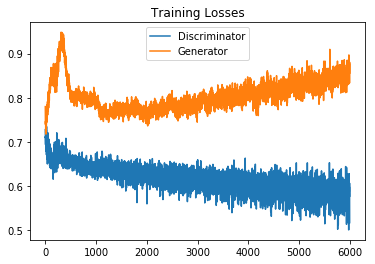

In [9]:
losses = np.array(gan.losses)

fig, ax = plt.subplots()
plt.plot([i[0][0] for i in losses], label='Discriminator')
plt.plot([i[1] for i in losses], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

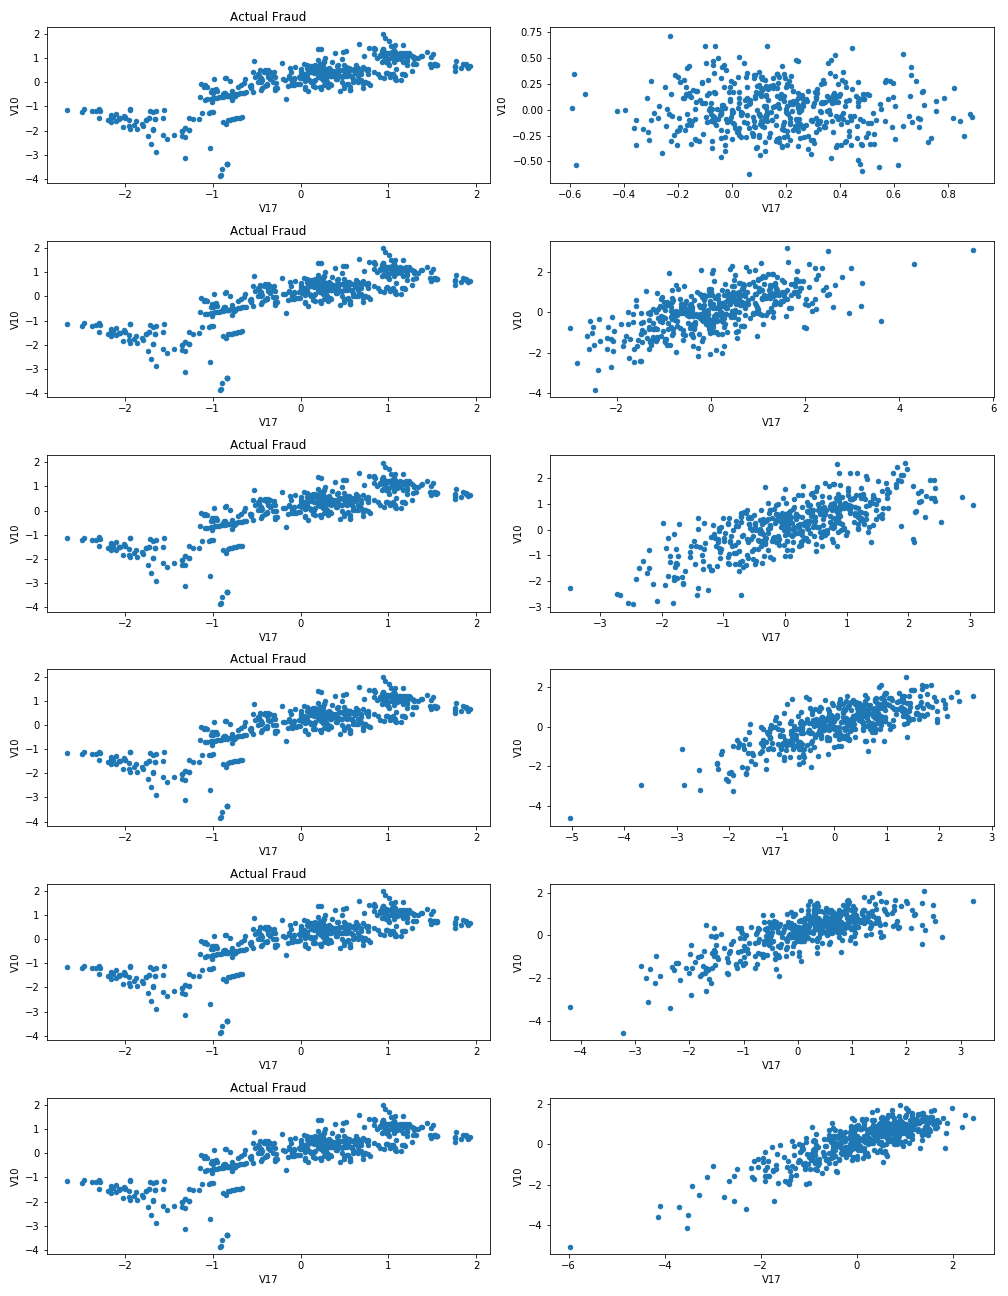

In [10]:
from IPython.display import Image
Image(filename='GANv1-v17-v10-img_600.png')

In [ ]:
plt.figure()

In [ ]:
plt.close()

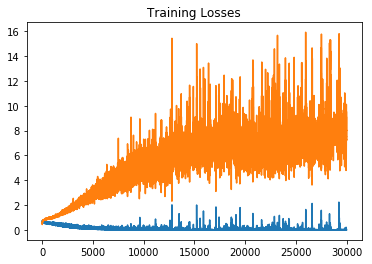

In [68]:
fig